In [ ]:
# Necessary installments for pandas_ta library to work...

!pip uninstall numpy -y
!pip install numpy==1.26.4  # Downgrade to a stable version
!pip uninstall pandas_ta -y
!pip install pandas_ta --no-cache-dir

# RESTART RUNTIME (ΠΕΡΙΟΔΟΣ ΛΕΙΤΟΥΡΓΙΑΣ) AFTER PANDAS_TA IS INSTALLED AND THEN RUN THE REST OF THE CELLS

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 86.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=1b57bc4139d432dff4d9b8648680ad48f46a81bd34f6e10fd91d2510bb2385ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-av_5r7ic/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [ ]:
import yfinance as yf
import requests
import numpy as np
import pandas as pd
import pandas_ta as ta
from datetime import date
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [ ]:
# Read, clean the data and calculate btc volatility & technical indicators


# Download Fear and Greed Index data
url = 'https://api.alternative.me/fng/?limit=0&format=json'
response = requests.get(url)
data = response.json()

# Parse the data
fear_greed = pd.DataFrame(data['data'])
fear_greed['timestamp'] = pd.to_datetime(fear_greed['timestamp'].astype(int), unit='s').dt.date
fear_greed.set_index('timestamp', inplace=True)
fear_greed['value'] = fear_greed['value'].astype(int)
fear_greed = fear_greed[['value']]
fear_greed.columns = ['FearGreedIndex']
fear_greed = fear_greed.rename_axis('Date')

# Clean the data
btc = pd.read_csv('/BTC-USD.csv', thousands = ',')[['Date','Price','Vol.']]
sp500 = pd.read_csv('/S&P 500.csv', thousands = ',')[['Date','Price']]
nasdaq = pd.read_csv('/NASDAQ.csv', thousands = ',')[['Date','Price']]
gold = pd.read_csv('/GOLD.csv', thousands = ',')[['Date','Price']]
dxy = pd.read_csv('/DXY.csv', thousands = ',')[['Date','Price']]
tnx = pd.read_csv('/TNX.csv', thousands = ',')[['Date','Price']]
vix = pd.read_csv('/VIX.csv', thousands = ',')[['Date','Price']]

btc['Vol.'] = btc['Vol.'].str.replace('K','').astype(float)
btc['Vol.'] = btc['Vol.']*1000

# Convert the date to datetime
btc['Date'] =  pd.to_datetime(btc['Date']).dt.date
sp500['Date'] =  pd.to_datetime(sp500['Date']).dt.date
nasdaq['Date'] =  pd.to_datetime(nasdaq['Date']).dt.date
gold['Date'] =  pd.to_datetime(gold['Date']).dt.date
dxy['Date'] =  pd.to_datetime(dxy['Date']).dt.date
tnx['Date'] =  pd.to_datetime(tnx['Date']).dt.date
vix['Date'] =  pd.to_datetime(vix['Date']).dt.date


# Set 'Date' as the index
btc.set_index('Date', inplace=True)
sp500.set_index('Date', inplace=True)
nasdaq.set_index('Date', inplace=True)
gold.set_index('Date', inplace=True)
dxy.set_index('Date', inplace=True)
tnx.set_index('Date', inplace=True)
vix.set_index('Date', inplace=True)

# Rename columns
btc.rename(columns={'Price': 'BTC', 'Vol.': 'Volume'},inplace=True)
sp500.rename(columns={'Price': 'SP500'},inplace=True)
nasdaq.rename(columns={'Price': 'NASDAQ'},inplace=True)
gold.rename(columns={'Price': 'GOLD'},inplace=True)
dxy.rename(columns={'Price': 'DXY'},inplace=True)
tnx.rename(columns={'Price': 'TNX'},inplace=True)
vix.rename(columns={'Price': 'VIX'},inplace=True)


# Start with the first DataFrame (btc) and merge the others on 'Date'
og_data = pd.merge(btc, sp500, on='Date', how='left')  # 'inner' keeps only matching dates
og_data = pd.merge(og_data, nasdaq, on='Date', how='left')
og_data = pd.merge(og_data, gold, on='Date', how='left')
og_data = pd.merge(og_data, dxy, on='Date', how='left')
og_data = pd.merge(og_data, tnx, on='Date', how='left')
og_data = pd.merge(og_data, vix, on='Date', how='left')
og_data = pd.merge(og_data, fear_greed, on='Date', how='left')

# Sort by date
og_data = og_data.sort_values(by="Date", ascending = True)

# First calculate daily returns
og_data['BTC_Volatility'] = og_data['BTC'].pct_change(fill_method=None).rolling(window=14).std()

#Calculate RSI
og_data["RSI"] = ta.rsi(og_data["BTC"], length=14)

#Calculate SMAs
og_data["SMA_50"] = ta.sma(og_data["BTC"], length=50)
og_data["SMA_100"] = ta.sma(og_data["BTC"], length=100)
og_data["SMA_200"] = ta.sma(og_data["BTC"], length=200)

#Calculate Bollinger Bands
bbands = ta.bbands(og_data["BTC"], length=20, std=2)
og_data["BB_upper"] = bbands["BBU_20_2.0"]
og_data["BB_middle"] = bbands["BBM_20_2.0"]
og_data["BB_lower"] = bbands["BBL_20_2.0"]

In [ ]:
# Train test on shuffled 80,20 data and evaluate

og_data['BTC_Tomorrow'] = og_data['BTC'].shift(-1)

# Drop NaN values so we test our data (and save it to a new df because the last row will be deleted)
og_data2 = og_data.dropna()

In [ ]:
features = ['Volume', 'SP500', 'NASDAQ', 'GOLD','DXY','TNX','VIX','FearGreedIndex','BTC_Volatility','RSI','SMA_50','SMA_100','SMA_200','BB_upper','BB_middle','BB_lower']
target = 'BTC_Tomorrow'

### Split data based on date ###
# cutoff_date =  pd.to_datetime('2025-4-22')
# today_date = pd.to_datetime(date.today()) - pd.Timedelta(days=1)
train_data = og_data2
test_data = train_data.copy()

# 3. Split features and targets
X_train = train_data[features]
y_train = train_data[[target]]

X_test = test_data[features]
y_test = test_data[[target]]

# 4. Scale using only the training data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_train_scaled = feature_scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train)

X_test_scaled = feature_scaler.transform(X_test)
y_test_scaled = target_scaler.transform(y_test)


In [ ]:
# Set the time steps

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 1
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)


In [ ]:
# Model settings

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (usually validation loss)
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# First, create all sample weights = 1
sample_weights = np.ones(len(y_train_seq))

# Then boost the last ~150 samples (5 months)
sample_weights[-150:] = 10  # 10x more important for recent data

# Pass the callback to the model.fit method
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=200,
    batch_size=32,
    validation_split=0.05,
    shuffle=True)

  # sample_weight=sample_weights
  # callbacks=[early_stopping])  - if we want to add the early stopping callback

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,825 (210.25 KB)

 Trainable params: 53,825 (210.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0597 - val_loss: 0.0482
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0059 - val_loss: 0.0043
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 11/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 12/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0

In [ ]:
# Inverse the data scaling

predictions_scaled = model.predict(X_train_seq)
predictions = target_scaler.inverse_transform(predictions_scaled)
y_test_actual = target_scaler.inverse_transform(y_train_seq)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


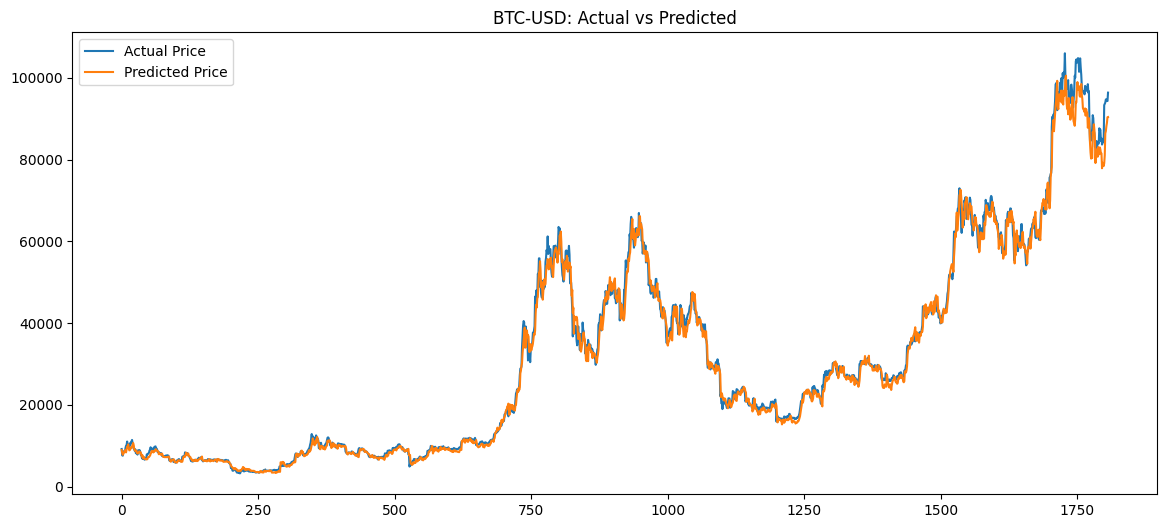

In [ ]:
# Plot actual vs predicted

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.legend()
plt.title('BTC-USD: Actual vs Predicted')
plt.show()

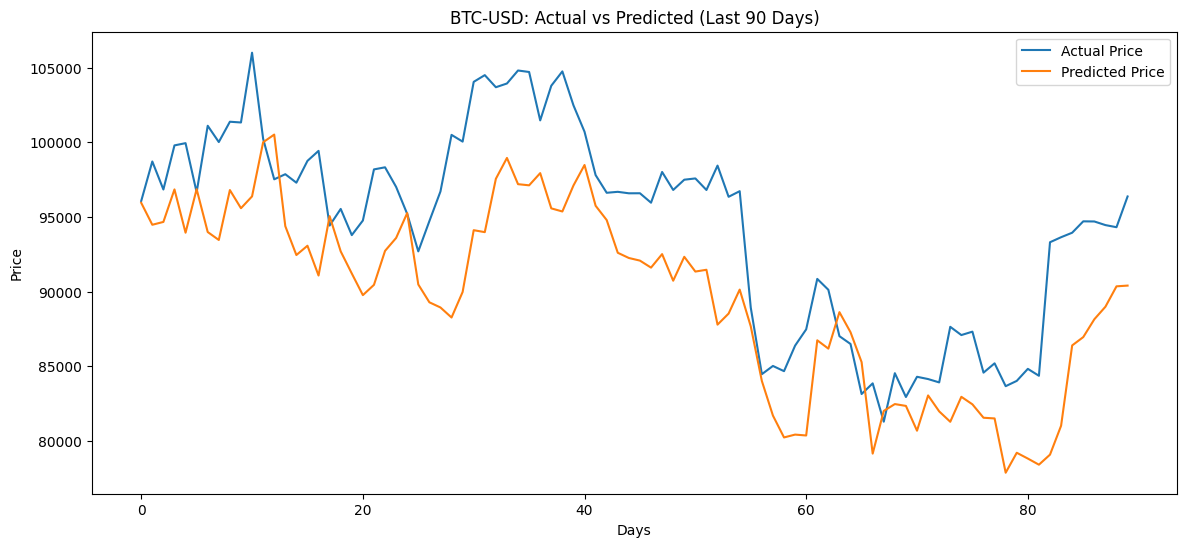

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test_actual and predictions are already calculated

# Get the last 90 days of data
last_30_days_actual = y_test_actual[-90:]
last_30_days_predictions = predictions[-90:]

plt.figure(figsize=(14, 6))
plt.plot(last_30_days_actual, label='Actual Price')
plt.plot(last_30_days_predictions, label='Predicted Price')
plt.legend()
plt.title('BTC-USD: Actual vs Predicted (Last 90 Days)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

In [ ]:
# Model evaluation

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)
mape = mean_absolute_percentage_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2_score(y_test_actual, predictions):.4f}")
print(f"MAPE: {mape:}")
print(f'MSE: {mse:.2f}')

RMSE: 2153.39
MAE: 1353.54
R2 Score: 0.9927
MAPE: 0.048607179668529274
MSE: 4637103.49


In [ ]:
columns_to_fill = ['Volume', 'SP500', 'NASDAQ', 'GOLD','DXY','TNX','VIX','FearGreedIndex','BTC_Volatility','RSI','SMA_50','SMA_100','SMA_200','BB_upper','BB_middle','BB_lower']
og_data[columns_to_fill] = og_data[columns_to_fill].ffill()

# 1. Get the last day's data
last_day_data = og_data[features].iloc[-1]  # Assuming 'features' is defined as before

# 2. Reshape the data to match the model's input shape
last_day_data = last_day_data.values.reshape(1, -1)

# 3. Scale the data using the previously fitted scaler
last_day_data_scaled = feature_scaler.transform(last_day_data)

# 4. Create a sequence for prediction

last_day_data_seq = np.repeat(last_day_data_scaled, TIME_STEPS, axis=0)
last_day_data_seq = last_day_data_seq.reshape(1, TIME_STEPS, -1)

# 5. Make the prediction
prediction_scaled = model.predict(last_day_data_seq)

# 6. Inverse transform to get the actual price prediction
prediction = target_scaler.inverse_transform(prediction_scaled)

# 7. Print the prediction
print(f"Predicted BTC price for the next day: ${prediction[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted BTC price for the next day: $92230.80


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


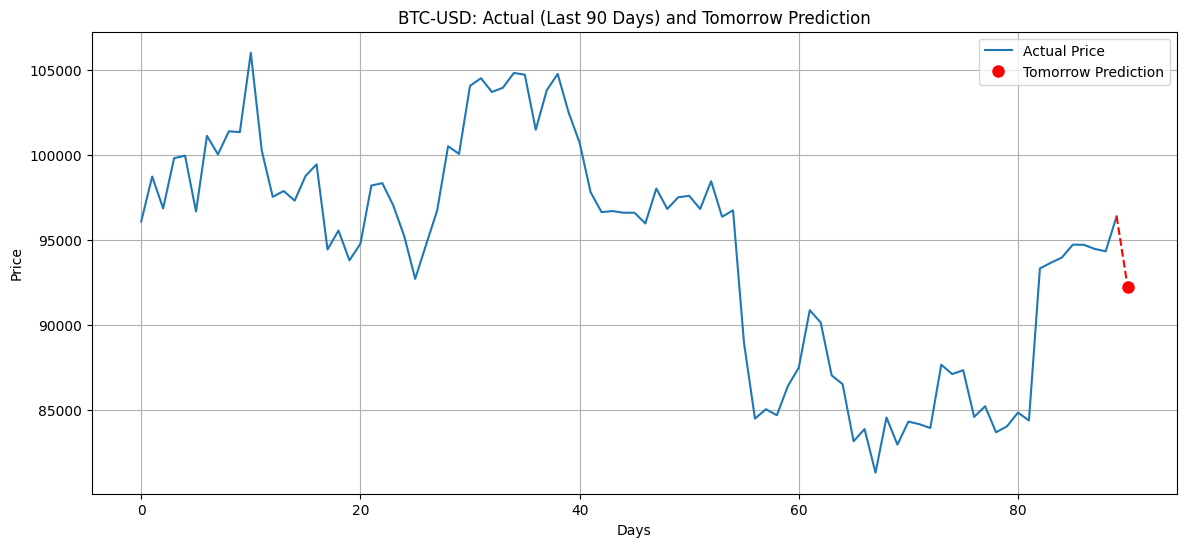

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_actual and prediction (from previous steps) are available

# Get the last 90 days of actual data
last_90_days_actual = y_test_actual[-90:]

# Create x-axis values for plotting
days = np.arange(len(last_90_days_actual))

# Plot the actual data
plt.figure(figsize=(14, 6))
plt.plot(days, last_90_days_actual, label='Actual Price')

# Plot the prediction for tomorrow (dotted line)
# Extract the scalar value from prediction
tomorrow_prediction = prediction[0][0]
plt.plot(days[-1] + 1, tomorrow_prediction, 'ro', label='Tomorrow Prediction', markersize=8)  # Red dot for prediction

# Use the extracted scalar value for consistent shape
plt.plot([days[-1], days[-1] + 1], [last_90_days_actual[-1, 0], tomorrow_prediction], 'r--')  # Dotted red line connecting to prediction


plt.legend()
plt.title('BTC-USD: Actual (Last 90 Days) and Tomorrow Prediction')
plt.grid()
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()